In [1]:
%%time

import json
reviews = []
with open("yelp_academic_dataset_review.json") as f:
    for line in f:
        reviews.append(json.loads(line))

CPU times: user 39.8 s, sys: 4.75 s, total: 44.5 s
Wall time: 44 s


In [2]:
print(reviews[0])

{'stars': 5, 'funny': 0, 'useful': 0, 'review_id': 'NxL8SIC5yqOdnlXCg18IBg', 'business_id': '2aFiy99vNLklCx3T_tGS9A', 'user_id': 'KpkOkG6RIf4Ra25Lhhxf1A', 'type': 'review', 'text': "If you enjoy service by someone who is as competent as he is personable, I would recommend Corey Kaplan highly. The time he has spent here has been very productive and working with him educational and enjoyable. I hope not to need him again (though this is highly unlikely) but knowing he is there if I do is very nice. By the way, I'm not from El Centro, CA. but Scottsdale, AZ.", 'date': '2011-10-10', 'cool': 0}


In [126]:
from collections import Counter
prolific_reviewers = Counter([review['user_id'] for review in reviews]).most_common(30)

In [127]:
keep_ids = {pr[0] : 0 for pr in prolific_reviewers}

In [128]:
by_author = {} # author : "review 1\n review 2\n review 3"
for review in reviews:
    uid = review['user_id']
    if uid in keep_ids:
        uid = review['user_id']
        if uid in by_author:
            by_author[uid] += "\n{}".format(review['text'])
        else:
            by_author[uid] = "{}".format(review['text'])


In [129]:
len(by_author)

30

In [130]:
# check that we have at least 200000 characters for each author
sorted([(len(by_author[key]), key) for key in by_author])[:5]

[(276136, 'ffPY_bHX8vLebHu8LBEqfg'),
 (278427, 'PeLGa5vUR8_mcsn-fn42Jg'),
 (351311, 'cMEtAiW60I5wE_vLfTxoJQ'),
 (370129, 'iDlkZO2iILS8Jwfdy7DP9A'),
 (461333, 'dt9IHwfuZs9D9LOH7gjNew')]

In [132]:
def get_chunks(l, n):
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

In [133]:
train_texts = []  # the first 100 000 chars from each author
train_labels = [] # each author
test_texts = []   # 100 texts of 1000 characters each (second 100 000 chars of each author)
test_labels = []  # each author * 100

author_int = {author: i for i,author in enumerate(by_author)}
int_author = {author_int[author]: author for author in author_int}

for author in by_author:
    train_text = by_author[author][:50000]
    train_label = author_int[author]
    train_texts.append(train_text)
    train_labels.append(train_label)
    
    short_texts = get_chunks(by_author[author][50000:100000], 1000)
    for text in short_texts:
        test_texts.append(text)
        test_labels.append(author_int[author])

In [134]:
print(len(train_texts), len(test_texts))

30 1500


In [135]:
len(train_texts[0])

50000

In [136]:
# vectorization - chars to ints
import string
import random
import sys

import numpy as np

from keras.models import load_model

def sample(preds, temperature=1.0):
    """Sample predictions from a probability array"""
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-6) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate(model, diversity=0.5, text=""):
    """Generate text from a model"""
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)

    for i in range(5000):
        x = np.zeros((1, maxlen), dtype=np.int)
        for t, char in enumerate(sentence):
            try:
                x[0, t] = char_indices[char]
            except:
                print(sentence)
        preds = model.predict(x, verbose=0)[0][0]
        next_index = sample(preds, diversity)
        next_char = indices_char[next_index]
        generated += next_char
        sentence = sentence[1:] + next_char
        sys.stdout.write(next_char)
        sys.stdout.flush()
    return

def vectorize(text):
    """Convert text into character sequences"""
    step = 3
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    X = np.zeros((len(sentences), maxlen), dtype=np.int)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t] = char_indices[char]
        y[i, char_indices[next_chars[i]]] = 1
    return X, y

def clean_text(text, charset):
    text = " ".join(text.split())  # all white space is one space
    text = "".join([x for x in text if x in charset])  # remove characters that we don't care about
    return text

def get_model(modelfile, freeze=False):
    model = load_model(modelfile)
    if freeze:
        for layer in model.layers[:-5]:
            layer.trainable = False
    return model

chars = " " + string.ascii_letters + string.punctuation  # sorted to keep indices consistent
charset = set(chars)  # for lookup
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

maxlen = 100  # must match length which generated model - the sequence length

# load a pretrained language model
modelfile = "charlm2/model_middlemarch_cnn.hdf5"

In [137]:
# test train an author specific model
test_author_text = clean_text(train_texts[0], charset)
test_author_model = get_model(modelfile, freeze=True)
X, y = vectorize(test_author_text)

In [138]:
test_texts[0]

"item. They were very tender, fall off the bone, and flavorful. The green chili potato was ok, but really not as special as I would expect for a restaurant's signature item. It is essentially a twice baked potato, but instead of putting the potato innards back into the potato skin, they stuff it into a pepper.... I thought the pepper was too firm and the flavors didn't completely complement each other. The filling could have been seasoned better. The sliders were alright, they were like little french dips sort of with chilies on top. I didn't love them, they just weren't that flavorful or special. The worst dish of the night was the tostadas... they lacked flavor, fell apart, and just were boring. When a menu states that when you order chilies, you're responsible for the heat level, I expect something will be spicy... but nothing was. I liked this place alright overall, but it was a bit inconsistent. I would probably come back for happy hour, but it wouldn't be my first choice in town.

In [140]:
test_author_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [141]:
# check that we don't overfit on 10 epochs
test_author_model.fit(X, [y, y], epochs=10, batch_size=128, validation_split=0.1)

Train on 14929 samples, validate on 1659 samples
Epoch 1/10
14929/14929 [==============================] - 12s - loss: 4.3390 - main_out_loss: 2.1570 - aux_out_loss: 2.1820 - val_loss: 3.8408 - val_main_out_loss: 1.8432 - val_aux_out_loss: 1.9976
Epoch 2/10
14929/14929 [==============================] - 10s - loss: 4.1144 - main_out_loss: 2.0119 - aux_out_loss: 2.1025 - val_loss: 3.7507 - val_main_out_loss: 1.7889 - val_aux_out_loss: 1.9619
Epoch 3/10
14929/14929 [==============================] - 10s - loss: 3.9888 - main_out_loss: 1.9290 - aux_out_loss: 2.0598 - val_loss: 3.7181 - val_main_out_loss: 1.7673 - val_aux_out_loss: 1.9508
Epoch 4/10
14929/14929 [==============================] - 10s - loss: 3.8903 - main_out_loss: 1.8674 - aux_out_loss: 2.0230 - val_loss: 3.6922 - val_main_out_loss: 1.7519 - val_aux_out_loss: 1.9403
Epoch 5/10
14929/14929 [==============================] - 10s - loss: 3.8253 - main_out_loss: 1.8237 - aux_out_loss: 2.0016 - val_loss: 3.6625 - val_main_out_l

In [142]:
scores = []
for text in test_texts[:100]:
    X, y = vectorize(clean_text(text, charset))
    score = test_author_model.evaluate(X, [y, y])
    scores.append(score[0])

288/294 [============================>.] - ETA: 0s

In [143]:
len(test_texts)

1500

In [145]:
from statistics import mean

print(mean(scores[:50]))
print(mean(scores[50:]))

3.80500852288
5.88146182806


In [146]:
len(scores)

100

In [147]:
%matplotlib inline
from matplotlib import pyplot as plt

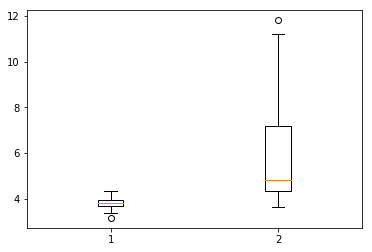

In [149]:
plt.boxplot(get_chunks(scores, 50)[:20]);

In [78]:
scores[:10]

[2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473,
 2.1628624592851473]

In [74]:
test_labels[100]

1

In [150]:
generate(test_author_model, diversity=0.3, text="this is some test text does it really matter what it says "*30)

----- Generating with seed: "does it really matter what it says this is some test text does it really matter what it says this is"
does it really matter what it says this is some test text does it really matter what it says this is the superior for breakfast from the staby and the consect was an instant something which was strength and the stabbit was the fact of the same start, which was stead of the same so those the flaos, was started and did not the sing which was something to be a little than the profese and the shock had been a little thing it was the constant that would be a little was stayful and got the means that which was staying the too streak in the new difficult in a strike and she had been distingun is a rash strength and the social distakes busina the fact the side of the same stands in the satisfactory was intention that she was great the side of the stick pocket (the sin had the state of the sub lady in the sat at the same time (lower because they were the same that w

In [151]:
len(train_texts)

30

In [152]:
author_models = []  # [(author_model, author_id), (author_model, author_id), ...] - ids are ints
for i, train_text in enumerate(train_texts):
    print("iteration {}, author_id: {}".format(i, train_labels[i]))
    ct = clean_text(train_text, charset)
    am = get_model(modelfile, freeze=True)
    am.compile(loss='categorical_crossentropy', optimizer='adam')
    X, y = vectorize(ct)
    am.fit(X, [y, y], epochs=10, batch_size=128)
    author_models.append((am, train_labels[i]))

iteration 0, author_id: 0
Epoch 1/10
16588/16588 [==============================] - 12s - loss: 4.2805 - main_out_loss: 2.1183 - aux_out_loss: 2.1621    
Epoch 2/10
16588/16588 [==============================] - 10s - loss: 4.0678 - main_out_loss: 1.9850 - aux_out_loss: 2.0828    
Epoch 3/10
16588/16588 [==============================] - 10s - loss: 3.9437 - main_out_loss: 1.9022 - aux_out_loss: 2.0414    
Epoch 4/10
16588/16588 [==============================] - 10s - loss: 3.8604 - main_out_loss: 1.8497 - aux_out_loss: 2.0107    
Epoch 5/10
16588/16588 [==============================] - 10s - loss: 3.7893 - main_out_loss: 1.8011 - aux_out_loss: 1.9882    
Epoch 6/10
16588/16588 [==============================] - 10s - loss: 3.7332 - main_out_loss: 1.7678 - aux_out_loss: 1.9654    
Epoch 7/10
16588/16588 [==============================] - 10s - loss: 3.6906 - main_out_loss: 1.7407 - aux_out_loss: 1.9499    
Epoch 8/10
16588/16588 [==============================] - 10s - loss: 3.6542 -

16419/16419 [==============================] - 10s - loss: 4.5722 - main_out_loss: 2.2623 - aux_out_loss: 2.3099    
Epoch 4/10
16419/16419 [==============================] - 10s - loss: 4.4824 - main_out_loss: 2.2037 - aux_out_loss: 2.2787    
Epoch 5/10
16419/16419 [==============================] - 10s - loss: 4.3920 - main_out_loss: 2.1389 - aux_out_loss: 2.2531    
Epoch 6/10
16419/16419 [==============================] - 10s - loss: 4.3339 - main_out_loss: 2.0992 - aux_out_loss: 2.2347    
Epoch 7/10
16419/16419 [==============================] - 10s - loss: 4.2794 - main_out_loss: 2.0642 - aux_out_loss: 2.2152    
Epoch 8/10
16419/16419 [==============================] - 10s - loss: 4.2283 - main_out_loss: 2.0291 - aux_out_loss: 2.1992    
Epoch 9/10
16419/16419 [==============================] - 10s - loss: 4.1888 - main_out_loss: 2.0047 - aux_out_loss: 2.1841    
Epoch 10/10
16419/16419 [==============================] - 10s - loss: 4.1531 - main_out_loss: 1.9848 - aux_out_los

16304/16304 [==============================] - 10s - loss: 4.1480 - main_out_loss: 1.9942 - aux_out_loss: 2.1539    
Epoch 6/10
16304/16304 [==============================] - 10s - loss: 4.0924 - main_out_loss: 1.9573 - aux_out_loss: 2.1350    
Epoch 7/10
16304/16304 [==============================] - 10s - loss: 4.0463 - main_out_loss: 1.9303 - aux_out_loss: 2.1160    
Epoch 8/10
16304/16304 [==============================] - 10s - loss: 3.9906 - main_out_loss: 1.8931 - aux_out_loss: 2.0975    
Epoch 9/10
16304/16304 [==============================] - 10s - loss: 3.9525 - main_out_loss: 1.8705 - aux_out_loss: 2.0820    
Epoch 10/10
16304/16304 [==============================] - 10s - loss: 3.9160 - main_out_loss: 1.8459 - aux_out_loss: 2.0701    
iteration 13, author_id: 13
Epoch 1/10
16523/16523 [==============================] - 13s - loss: 4.0897 - main_out_loss: 2.0214 - aux_out_loss: 2.0682    
Epoch 2/10
16523/16523 [==============================] - 10s - loss: 3.9643 - main_ou

16533/16533 [==============================] - 10s - loss: 3.8853 - main_out_loss: 1.8419 - aux_out_loss: 2.0434    
Epoch 8/10
16533/16533 [==============================] - 10s - loss: 3.8489 - main_out_loss: 1.8191 - aux_out_loss: 2.0298    
Epoch 9/10
16533/16533 [==============================] - 10s - loss: 3.8148 - main_out_loss: 1.7984 - aux_out_loss: 2.0164    
Epoch 10/10
16533/16533 [==============================] - 10s - loss: 3.7799 - main_out_loss: 1.7782 - aux_out_loss: 2.0017    
iteration 19, author_id: 19
Epoch 1/10
16432/16432 [==============================] - 13s - loss: 4.4749 - main_out_loss: 2.2355 - aux_out_loss: 2.2395    
Epoch 2/10
16432/16432 [==============================] - 10s - loss: 4.2154 - main_out_loss: 2.0694 - aux_out_loss: 2.1460    
Epoch 3/10
16432/16432 [==============================] - 10s - loss: 4.0629 - main_out_loss: 1.9734 - aux_out_loss: 2.0895    
Epoch 4/10
16432/16432 [==============================] - 10s - loss: 3.9493 - main_ou

16514/16514 [==============================] - 10s - loss: 3.8644 - main_out_loss: 1.8212 - aux_out_loss: 2.0432    
Epoch 10/10
16514/16514 [==============================] - 10s - loss: 3.8271 - main_out_loss: 1.7968 - aux_out_loss: 2.0304    
iteration 25, author_id: 25
Epoch 1/10
16379/16379 [==============================] - 14s - loss: 4.3433 - main_out_loss: 2.1602 - aux_out_loss: 2.1831    
Epoch 2/10
16379/16379 [==============================] - 10s - loss: 4.1899 - main_out_loss: 2.0576 - aux_out_loss: 2.1323    
Epoch 3/10
16379/16379 [==============================] - 10s - loss: 4.0781 - main_out_loss: 1.9753 - aux_out_loss: 2.1028    
Epoch 4/10
16379/16379 [==============================] - 10s - loss: 4.0012 - main_out_loss: 1.9236 - aux_out_loss: 2.0777    
Epoch 5/10
16379/16379 [==============================] - 10s - loss: 3.9286 - main_out_loss: 1.8770 - aux_out_loss: 2.0516    
Epoch 6/10
16379/16379 [==============================] - 10s - loss: 3.8910 - main_ou

In [153]:
print(len(author_models))
print(len(test_texts))
print(len(test_labels))

30
1500
1500


In [178]:
word_counts = [text.count(" ") for text in test_texts]
mean(word_counts)

182.57733333333334

In [156]:
from random import shuffle
indicies = list(range(len(test_texts)))

test_texts = np.array(test_texts)
test_labels = np.array(test_labels)

test_texts = test_texts[indicies]
test_labels = test_labels[indicies]

predictions = []
for text in test_texts:
    X, y = vectorize(clean_text(text, charset))
    
    losses = []
    for am in author_models:
        model = am[0]
        label = am[1]
        loss = model.evaluate(X, [y, y])
        losses.append((loss[0], label))
    predictions.append(losses)
    


288/288 [==============================] - 0s     


288/288 [==============================] - 0s     


287/287 [==============================] - 0s     


283/283 [==============================] - 0s     


288/297 [============================>.] - ETA: 0s

In [157]:
len(predictions)

1500

In [165]:
pred_is = []
for pred in predictions:
    pred_i = [p[0] for p in pred]
    pred_is.append(pred_i)

In [169]:
pred_labs = [np.argmin(pred) for pred in pred_is]

In [171]:
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, pred_labs)

0.53800000000000003

In [123]:
test_author_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 100, 300)      25500       input_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100, 300)      0           embedding_1[0][0]                
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 96, 64)        96064       dropout_1[0][0]                  
___________________________________________________________________________________________

In [125]:
test_author_model.evaluatei

<bound method Model.evaluate of <keras.engine.training.Model object at 0x7f7457285b70>>